## Training Convolutional Neural Networks
In this notebook we train a convolutional neural network for image classification. Our goal here is to compare convolutional networks to fully-connected (dense) networks with a **similar** number of parameters, demonstrating their ability to exploit inherent structures and properties of natural images.

Since we are going to use non-synthetic datasets, we use the *torchvision* package, which includes plenty of conventional data sets and methods for processing and manipluating data.


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# MNIST Dataset
The data we will use for training and inference is based on the common MNIST dataset. This dataset is comprised of $60,000$ training images and $10,000$ test images. Each is a $28\times 28$ image of a single handwritten digit, and is associated with a categorical value in the set $0,\ldots,9$.

To load the data, we use:


1.   PyTorch's DataLoader to already organize the data is shuffled mini-batches of size $B=64$. The argument `shuffle=True` implies that the data gest reshuffled anew at every epoch.
2.   Torchvision's datasets.MNIST to access the data.
3.   Torchvisions's transforms to normalize the images.

Transforms are commonly used with image datasets in order to perform operations such as normalization, resizing, cropping etc.
Transforms are in general stacked together using a compose function and applied to the images in the dataset after converting them to a tensor. The only operation we need to perform upon MNIST images is the normalization.




In [19]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes
norm_mean = 0.5
norm_std = 0.5

train_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((norm_mean,), (norm_std,))
                   ])), batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=False,
                       transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((norm_mean,), (norm_std,))
                   ])), batch_size=1000, shuffle=True)

Printing how many images have we loaded.

In [20]:
# Print number of images
print(train_loader.dataset.__len__())
print(test_loader.dataset.__len__())
# image shape
data_sample = train_loader.dataset.__getitem__(0)
print(f'data sample shape is: {data_sample[0].shape}, with the label: {data_sample[1]}')
data_sample[0].min(), data_sample[0].max()


60000
10000
data sample shape is: torch.Size([1, 28, 28]), with the label: 5


(tensor(-1.), tensor(1.))

## Visuallizing the data
Let's see what this data looks like (squeezing each image from tensor representation to 2-dimensional image for presentation).
We use the *getitem* to simply access a single image from the training data set.

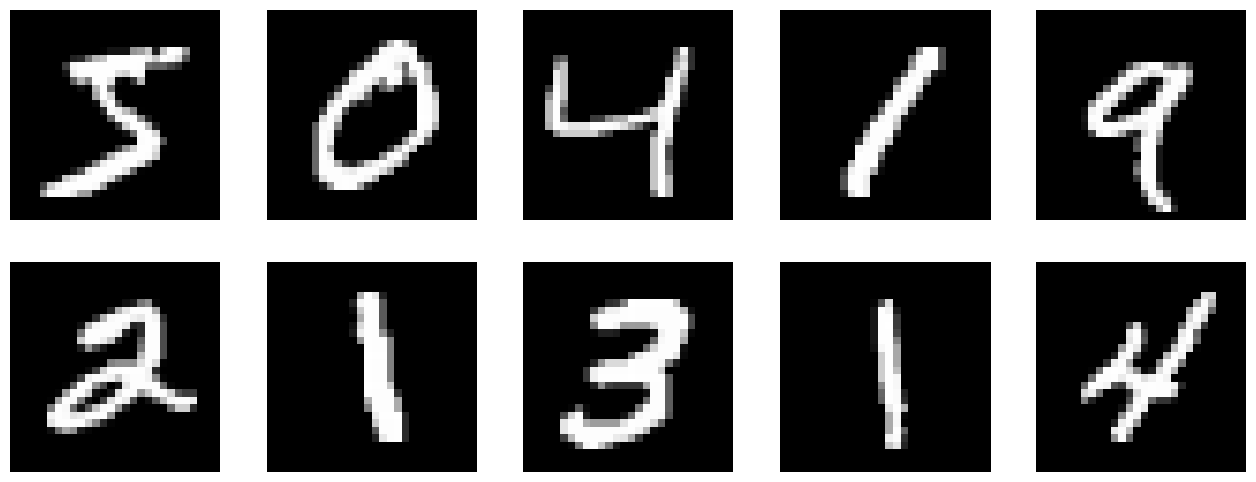

In [21]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, label = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy(), cmap='Greys_r') # squeeze Remove axes of length one
    plt.axis('off');

## Permuting the images
In the sequel we study the sensitivity of convoutional networks to non-structural perserving permutations of images. Specifiaclly, we will see that a convolutional network operates much better than a fully-connected one with the same number of trainable parameters due to its ability to **exploit the spatial structures** in the image.

So, let's visualize how dropping the structure of the images looks like. We do this by applying a random permutation of the pixels. This is what a permuted image looks like:

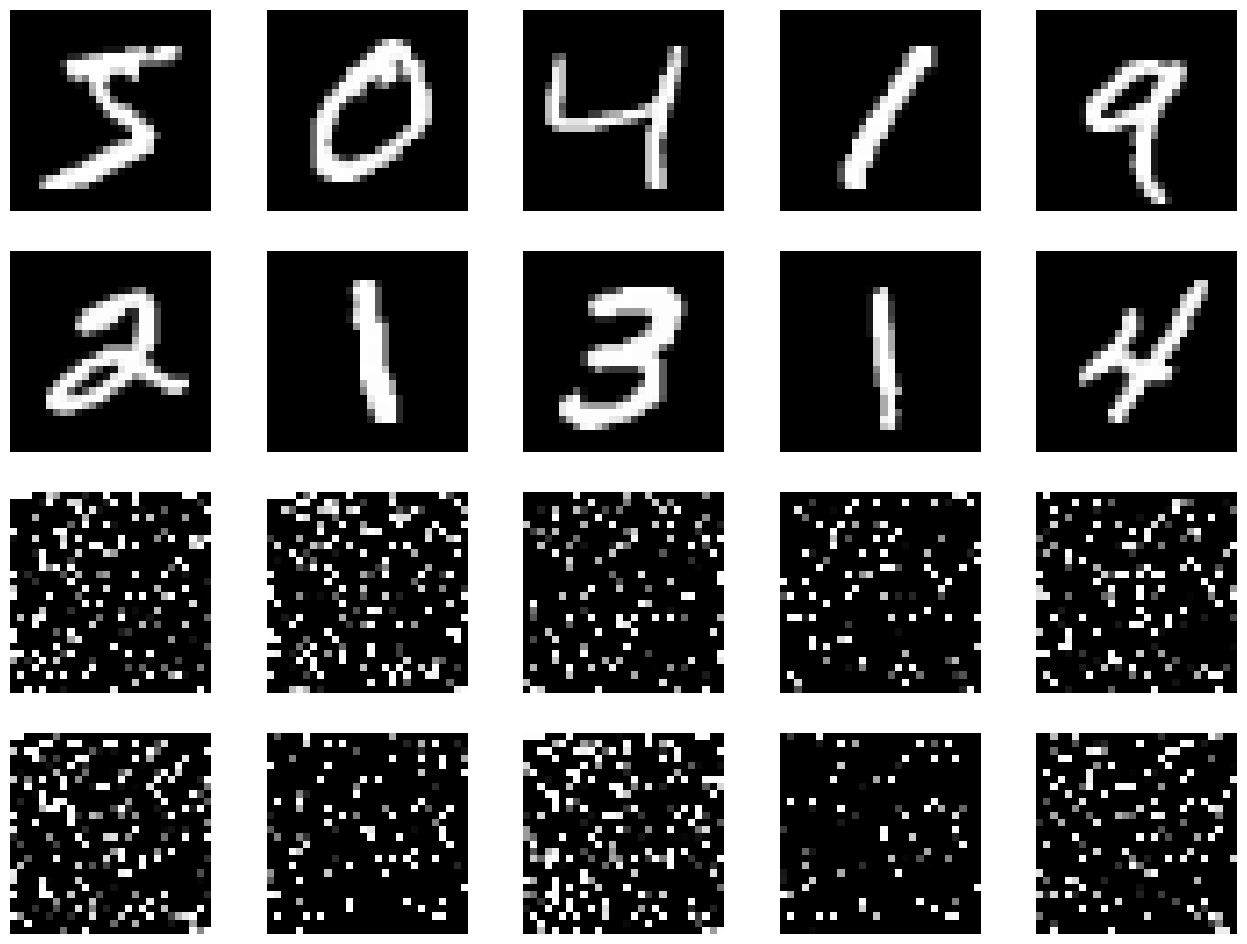

In [22]:
perm = torch.randperm(input_size)
plt.figure(figsize=(16, 12))
for i in range(10):
    image, label = train_loader.dataset.__getitem__(i)

    # permute pixels
    image_perm = image.view(input_size)
    image_perm = image_perm[perm]
    image_perm = image_perm.view(28, 28)

    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy(),cmap='Greys_r')
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.numpy(),cmap='Greys_r')
    plt.axis('off')

# Compar Neural Network Models



## Model 1: fully-connected
We use three layers where the hyperparemter `n_hidden` dictates the input-and-output size of the second hidden layer. The output is a log-softmax layer (same as softmax only with a log taken to improve stability).

The `tensor.view()` method just reshapes the tensor data to be of the desired input size, while the $-1$ simply states that we do not know (or care) about the number of images forwarded when reshaping. Note that each image is reshaped into  $1 \times 784$ vector as the fully-connected network treats the image as a vector of pixels. Specifically, the first diemnsion is the batch-size while the second is $H_1 \times W_1$.

In [23]:
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, output_size),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)

Next, we will compute the number of trainable parameters of the model when the second layer is comprised of merely $8$ hidden units.
For example, the number trainable parameters of the model's first layer is
$$
\text{Param \#} = n_{\text{hidden}}\,(H_1 W_1 + 1)
= 8\cdot(28\cdot 28 + 1) = 6{,}280.
$$

In [24]:
n_hidden = 8 # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size).to(device)
print(model_fnn)

from torchsummary import summary
summary(model_fnn, input_size=(1,28*28))

FC2Layer(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 8]           6,280
              ReLU-2                    [-1, 8]               0
            Linear-3                    [-1, 8]              72
              ReLU-4                    [-1, 8]               0
            Linear-5                   [-1, 10]              90
        LogSoftmax-6                   [-1, 10]               0
Total params: 6,442
Trainable params: 6,442
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB):

## Model 2: Convolutional neural network
The convolutional neural network is comprised of **two** convolutional layers subsequect by two fully-connetected ones. For the former, we have:

*   kernel size $F_c=5$
*   number of output channels $D_2$ is a hyperparameter termed `n_feature`, controlling the number of trainable parameters
* the number of input channels is $D_1=1$ as we have grayscale images
*   each convolutaional layer is followed by a ReLU activation and a MaxPooling layer with kernel size $F_p=2$.

Note changes in the dimensions over the layers:

- After the first convolution layer:
$$
H_1(=28)\times W_1(=28)\times D_1(=1)
\;\downarrow\;
H_2(=H_1-F_c+1)\times W_2(=W_1-F_c+1)\times D_2(=n_{\text{feature}})
=24\times 24\times n_{\text{feature}}.
$$

After MaxPooling (2×2), the size is reduced to:
$$
12\times 12\times n_{\text{feature}}.
$$

- Then, the second convolution layer converts to:
$$
H_3(=H_2-F_c+1)\times W_3(=W_2-F_c+1)\times D_3(=n_{\text{feature}})
=8\times 8\times n_{\text{feature}},
$$
which after MaxPooling is reduced to:
$$
4\times 4\times n_{\text{feature}}.
$$

For this reason, the input to the fully-connected layer is of size
$$
n_{\text{feature}}\cdot 4\cdot 4.
$$


In [25]:
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        x = x.view(-1, self.n_feature*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

Here also we print the overall number of trainable parameters when the number of channels is $D_2=6$.
For example, the number trainable parameters of the model's second layer is
$$
\text{Param \#} = n_{\text{feature}}\,(F_c^2\,n_{\text{feature}}+1)
= 6\,(5^2\cdot 6+1)=906.
$$

In [26]:
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size).to(device)
summary(model_cnn, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
            Conv2d-2              [-1, 6, 8, 8]             906
            Linear-3                   [-1, 50]           4,850
            Linear-4                   [-1, 10]             510
Total params: 6,422
Trainable params: 6,422
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.02
Estimated Total Size (MB): 0.06
----------------------------------------------------------------


# Tranining and Inference
Next, we define the functions which we will use for training and inference for hadnwritten digit recognition using the MNIST dataset.

We begin with a function for training over a single epoch (a complete loop over the dataset). Note that the function takes as input, in addition to the *epoch* index and the *model* structure, we include a variable indicating how to permute the pixels (comprised of $28^2=784$ entries). We will use this permutation in the sequel to study the sensitivity of convoutional networks to non-structural perserving permutations of images.

The optimizer we are using is SGD with momentum, and we use the negative log likelihood loss, which, when combined with log-softmax outputs, boils down to the cross-entropy loss.

The statement *model.train()* tells the model that we are training it. So effectively layers like dropout, batchnorm etc. which behave differently on the train and test procedures, behave accordingly. For the same reason, we use *model.eval()* in the test procedure.

In [27]:
from tqdm import tqdm
criterion = torch.nn.NLLLoss() # The input given through a forward call is expected to contain log-probabilities of each class.
def train(model, optimizer, perm=None):
    model.train()

    for epoch in range(epochs):
      with tqdm(train_loader, unit="batch") as tepoch:
        for batch_idx, (data, label) in enumerate(tepoch):
            tepoch.set_description(f"Epoch {epoch}")

            # send to device
            data, label = data.to(device), label.to(device)

            # permute pixels
            if perm is not None:
              data = data.view(-1, 28*28)
              data = data[:, perm]
              data = data.view(-1, 1, 28, 28)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            tepoch.set_postfix(batch_loss=loss.item()) # Tensor.item() → number returns the value of this tensor as a standard Python number. This only works for tensors with one element.

In [28]:
def test(model, perm=None):
    model.eval()
    test_loss = 0
    correct = 0

    with tqdm(test_loader, unit="batch") as loader:
      for data, label in loader:
          # send to device
          data, label = data.to(device), label.to(device)

          # permute pixels
          if perm is not None:
            data = data.view(-1, 28*28)
            data = data[:, perm]
            data = data.view(-1, 1, 28, 28)

          output = model(data)
          test_loss += F.nll_loss(output, label, reduction='sum').item() # sum up batch loss
          pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
          correct += pred.eq(label.data.view_as(pred)).cpu().sum().item()


    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {round(test_loss, 2)}, Accuracy: {correct}/{len(test_loader.dataset)} ({round(accuracy)}%)')
    return accuracy

## No permutation



Using `tqdm` we can easily monitor the training, showing the following fields:
Percentage completion; Progress bar; Number of items iterated over total number of items; {elapsed}<{remaining} running time; and batches per second.

Additionaly, we can manully add fields of interest as we did here with `epoch` and `loss`.

In [29]:
results = {}
epochs = 3
optimizer_fnn = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
train(model_fnn, optimizer_fnn)

Epoch 2: 100%|██████████| 938/938 [00:41<00:00, 22.77batch/s, batch_loss=0.784] 


In [30]:
results['NN image'] = test(model_fnn)

100%|██████████| 10/10 [00:04<00:00,  2.19batch/s]


Test set: Average loss: 0.36, Accuracy: 8924/10000 (89%)


In [31]:
optimizer_cnn = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
train(model_cnn, optimizer_cnn)

Epoch 2: 100%|██████████| 938/938 [00:50<00:00, 18.60batch/s, batch_loss=0.0835]


In [32]:
results['CNN image'] = test(model_cnn)

100%|██████████| 10/10 [00:05<00:00,  1.97batch/s]


Test set: Average loss: 0.09, Accuracy: 9703/10000 (97%)


## With added permutation

In [33]:
# get new models (to not use the weights learned with the raw images) and train from scratch with scrambeled images
model_fnn = FC2Layer(input_size, n_hidden, output_size).to(device)
optimizer_fnn = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
train(model_fnn, optimizer_fnn, perm)
results['NN scrambled'] = test(model_fnn, perm)


model_cnn = CNN(input_size, n_features, output_size).to(device)
optimizer_cnn = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
train(model_cnn, optimizer_cnn, perm)
results['CNN scrambled'] = test(model_cnn, perm)

100%|██████████| 10/10 [00:04<00:00,  2.32batch/s]



Test set: Average loss: 0.38, Accuracy: 8907/10000 (89%)


100%|██████████| 10/10 [00:05<00:00,  1.94batch/s]


Test set: Average loss: 0.35, Accuracy: 8925/10000 (89%)


# Summary
What do we see when comparing the convolutional network and the fully-connected one?

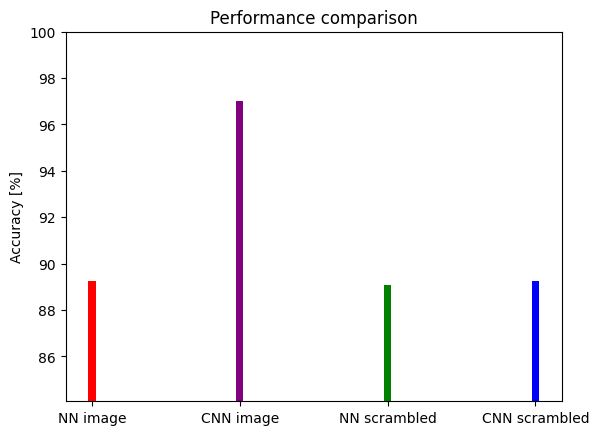

In [34]:
plt.bar(results.keys(), results.values(), width=0.05, color = ['red', 'purple', 'green', 'blue'])
plt.ylim((min(results.values())-5, 100))
plt.ylabel('Accuracy [%]')
plt.title('Performance comparison');